# Molecular dynamics simulation

Authors:
- Pietro Gerletti, CADD seminar 2020, Charité/FU Berlin
- Mareike Leja
- Jeffrey R Wagner
- David Schaller

__Note__

This talktorial was designed to be used with [Google Colab](https://colab.research.google.com/). It is also possible to use it on a local computer. However, performing the molecular dynamics simulation may take a considerably long time if no GPU is available.

## Aim of this talktorial

In this talktorial, we will learn why molecular dynamics (MD) simulations are important for drug design and which steps are neccessary to perform an MD simulation of a protein in complex with a ligand. The kinase EGFR will serve as sample system for simulation.

### Contents in *Theory*

- Molecular dynamics
- Force fields
- Boundary conditions
- MD simulations and drug design
- EGFR kinase

### Contents in *Practical*

- Installation on Google Colab
- Download pdb file
- Prepare the protein ligand comples
  - Prepare protein
  - Prepare ligand
- Merge protein and ligand
- MD simulation set up
  - Force field
  - System
- Perform the MD simulation
- Download results
- Discussion

### References

- Review on the impact of MD simulations in drug discovery ([_J Med Chem_ (2016), **59**(9), 4035‐4061](https://doi.org/10.1021/acs.jmedchem.5b01684))
- Review on the physics behind MD simulations and best practices ([_Living J Comp Mol Sci_ (2019), **1**(1), 5957](https://doi.org/10.33011/livecoms.1.1.5957))
- Review on force fields ([_J Chem Inf Model_ (2018), **58**(3), 565-578](https://doi.org/10.1021/acs.jcim.8b00042))
- Review on EGFR in cancer ([_Cancers (Basel)_ (2017), **9**(5), 52](https://dx.doi.org/10.3390%2Fcancers9050052))
- Pierre-Simon Laplace, Oeuvres Complètes de Laplace. Théorie Analytique des Probabilités (_volume VII Gauthier-Villars_ (1820), 3rd ed)
- Inspired by a notebook form Jaime Rodríguez-Guerra ([github](https://github.com/jaimergp/uab-msc-bioinf/blob/master/MD%20Simulation%20and%20Analysis%20in%20a%20Notebook.ipynb))
- Repositories of [OpenMM](https://github.com/openmm/openmmforcefields), [RDKit](https://github.com/rdkit/rdkit), [PyPDB](https://github.com/williamgilpin/pypdb), [MDTraj](https://github.com/mdtraj/mdtraj), [PDBFixer](https://github.com/openmm/pdbfixer)
- Wikipedia articles about [MD simulations](https://en.wikipedia.org/wiki/Molecular_dynamics), [AMBER](https://en.wikipedia.org/wiki/AMBER) and [Force Fields](https://en.wikipedia.org/wiki/Force_field_(chemistry)) in general

## Theory

### Molecular dynamics

Molecular dynamics is a computational method analyzing the movements and interactions of atoms and molecules of a defined system. The method stems from theoretical physics, where it was developed in the 1950s (Alder and Wainwright in [_J Chem Phys_ (1959), **31**(2), 459](https://doi.org/10.1063/1.1730376)), although the ideas behind it can be dated much earlier:

*'An intelligence which could, at  any moment, comprehend all the forces by  which nature is animated and the  respective positions of the  beings of which it is  composed, and moreover, if this intelligence were far-reaching enough to subject these data to  analysis, it would encompass in that formula both the movements of the  largest bodies in  the universe and those of the lightest atom: to it nothing would be uncertain, and the  future, as well as the past, would be present to its eyes. The human mind offers us, in the perfection which it has  given to  astronomy, a faint sketch of this intelligence.'*  
Pierre-Simon Laplace (1820)

Let us just take this statement by de Laplace as the ideological substrate underneath molecular dynamics simulations. In other terms, we can approximate the behavior of a physical system by knowing the characteristics of its components and applying Newton's laws of motion. By solving the equations of motion, we can obtain a molecular trajectory of the system, which is a series of snapshots with the positions and velocities of all its particles, as well as its potential energy. To do so, we define functions, called force fields, which provide an approximate description of all the forces applied to each particle in the system. We then use numerical integrators to solve the initial value problem for the system and obtain the trajectory. As it sounds, the process requires quite a bit of processing power and it was only few years ago that MD started seeing a more widespread use, especially in the field of computational chemistry and biology, as well as in drug discovery ([_J Med Chem_ (2016), **59**(9), 4035‐4061](https://doi.org/10.1021/acs.jmedchem.5b01684)).

![MD rotor](images/MD_rotor_250K_1ns.gif)

**Figure 1**: Molecular dynamics simulation of the rotation of a supramolecule composed of three molecules in a confined nanoscopic pore (Palma et al. via [Wikimedia](https://commons.wikimedia.org/w/index.php?curid=34866205)).

### Force fields



Force fields describe the forces between atoms within and between molecules. They are parametric equations with components for different forces (bond stretching, van-der-Waals and more). The parameter values are usually derived experimentally and change for each MD scenario, depending on the molecules involved and the simulation settings. The result is a mathematical description of the energy landscape of the system, in which the forces acting on each particle result from the gradient of the potential energy with respect to the coordinates of the atoms.

Several force fields are available, each with its own characteristics ([_J Chem Inf Model_ (2018), **58**(3), 565-578](https://doi.org/10.1021/acs.jcim.8b00042)). In this notebook, we will use a member of the AMBER force fields, which are widely used for MD simulations of proteins. Their functional form is:

$$V(r^N) = \sum_{i \in  bonds}k_{bi} (l_i-l^0_i)^2 + \sum_{i \in  angles}k_{ai}(\theta_i - \theta^0_i)^2 + \sum_{i\in torsions} \sum_n \frac{1}{2} V_i^n[1+cos(nw_i-\gamma_i)] + \sum_{j=1}^{N-1}\sum_{I=j+1}^{N} f_{ij}\in ij [(\frac{r^0_{ij}}{r_{ij}})^{12}-2(\frac{r^0_{ij}}{r_{ij}})^{6}]+\frac{q_iq_j}{4\pi \in_0 r_{ij}}$$

The formula consists of a sum of different components. The first three components contain information about bond lengths, angles and torsions (intramolecular forces). The last component describes intermolecular, non-bonded forces like Van-der-Waals forces and electrostatic interactions. The various parameters, denoted by a superscricpt 0, depend on the force field used and vary between all members of the AMBER force field family. Note that these force fields assume fixed-charge particles and do not allow polarization, nor do they consider how a local charge influences its surroundings. 

The following visual representation of force fields components shows the same concepts in a more intuitive way.

![force field](images/MM_PEF.png)

**Figure 2**: Components of a molecular mechanics force field (Edboas via [Wikimedia](https://commons.wikimedia.org/w/index.php?curid=4194424)).

### Boundary conditions

Often, molecular systems are simulated in a box filled with solvent such as water. These boxes are of finite size, which results in problems for molecules at or near the box boundaries. With which molecules should those interact? Periodic boundary conditions can avoid such boundary artifacts by simulating a theoretically infinite system. Molecules at one boundary of the box thereby interact with molecules at the boundary on the other side of the box. This mimics a situation, in which the simulation box is surrounded by replicas of itself. When visualizing such MD simulations, one can often observe that particles leave the box at one side (Fig. 3). However, they re-appear at the same time on the other side of the box with the same velocity. For simulations under periodic boundary conditions, it is recommended to use a simulation box large enough, so that the simulated macromolecule does not come into contact with neighbouring images of itself.

![MD_water](images/MD_water.gif)

**Figure 3**: Molecular dynamics simulation of water molecules with periodic boundary conditions (Kmckiern via [Wikimedia](https://commons.wikimedia.org/wiki/File:MD_water.gif)).

### MD simulations and drug design

MD simulations give valuable insights into the highly dynamic process of drugs binding to their target. When a ligand (drug) approaches a macromolecule (protein) in solution, it encounters a structure in constant motion. Also, ligands may induce conformational changes in the macromolecule, that can best accomodate the small molecule. Such conformations may not be discovered with static methods. Accordingly, binding sites that are not observed in static ligand-free structures, but can be discovered with MD Simulations, are sometimes called *cryptic binding sites* ([_J Med Chem_ (2016), **59**(9), 4035‐4061](https://doi.org/10.1021/acs.jmedchem.5b01684)). The identification of such binding sites with MD Simulation can kickstart new drug discovery campaigns. Later in the drug discovery process, MD simulations can also be used to estimate the quality of computationally identified small molecules before performing more costly and time-intensive in-vitro tests. Alltogether, MD Simulations pose a valuable asset in computational drug design. A more extensive introduction to applications of MD simulations in the context of drug design can be found in the following talktorial.

### EGFR kinase

The **E**pidermal **G**rowth **F**actor **R**eceptor (EGFR) is an important drug target with implications in cancer and inflammation ([wikipedia](https://en.wikipedia.org/wiki/Epidermal_growth_factor_receptor)). It is a transmembrane protein with an extracellular receptor domain and an intracellular kinase domain. The binding of the endogenous ligand epidermal growth factor results in activation of the kinase domain via dimerization and autophosphorylisation. The activated kinase domain can then phosphorylate downstream signaling proteins triggering DNA synthesis and cell proliferation ([_Cancers (Basel)_ (2017), **9**(5), 52](https://dx.doi.org/10.3390%2Fcancers9050052)). Inhibition of this kinase is the underlying mechanism of action of several already approved cancer drugs ([DrugBank](https://go.drugbank.com/bio_entities/BE0000767)). In this talktorial, we use the pdb structure of this kinase in complex with the small molecule inhibitor 8AM to perform an MD simulation ([RCSB](https://www.rcsb.org/structure/5ug9)).

![5UG9](images/5ug9_assembly-1.jpeg)

**Figure 4**: Structure of the EGFR kinase domain bound to inhibitor 8AM ([RCSB](https://www.rcsb.org/structure/5ug9)).

## Practical

We will now proceed to perform an MD simulation using the molecular dynamics engine `OpenMM`.

### Installation on Google Colab

Execute the following code cell, if on Google Colab. This notebook can also be used on a local computer but requires considerable computing power.

In [1]:
import sys
from IPython.display import clear_output
from google.colab import files

# download miniconda
!wget -q https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
!bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local

# install required modules
!conda install -q -y -c conda-forge -c omnia --prefix /usr/local/ python=3.6 openmm openmmforcefields rdkit pdbfixer mdtraj pypdb

# append path to enable running packages installed with conda
sys.path.append("/usr/local/lib/python3.6/site-packages")

# clear the excesive installation outputs
clear_output()

print("Dependencies successfully installed!")

Dependencies successfully installed!


In [2]:
# imports
import sys
import copy
from pathlib import Path

from IPython.display import display
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from pypdb import get_pdb_file
import mdtraj as md
import pdbfixer
import simtk.openmm as mm
import simtk.openmm.app as app
from simtk.openmm import unit
from openforcefield.topology import Molecule, Topology
from openmmforcefields.generators import GAFFTemplateGenerator

In [3]:
# create data directory if not exists
HERE = Path(_dh[-1])
DATA = HERE / "data"
DATA.mkdir(exist_ok=True)

### Download pdb file
The python package `pypdb` allows easy access to structures stored in the protein data bank ([PDB](https://www.rcsb.org/)).

In [4]:
pdbid = "5ug9"
pdb_path = DATA / (pdbid + ".pdb")
pdb_file_string = get_pdb_file(pdbid, filetype='pdb', compression=False)
with open(pdb_path, 'w') as f:
    f.write(pdb_file_string)

### Prepare the protein ligand complex

#### Protein preparation

A crucial part for successful simulation is a correct and complete system. Pdb files from crystallographic structures often miss atoms, mainly hydrogens, and may contain non-standard residues. In this talktorial, we will use the python package `pdbfixer` to prepare the protein structure. However, co-crystallized ligands are not handled well by `pdbfixer` and will thus be prepared separately.

In [5]:
def prepare_protein(pdb_file, ignore_missing_residues=True, ignore_terminal_missing_residues=True):
    """Use pdbfixer to prepare the protein from a pdb file. Hetero atoms such as ligands are 
    removed, nonstandard residues replaced and missing atoms added.
    
    Parameters
    ----------
    pdb_file: str
        Pdb file containing the system to simulate.
    ignore_missing_residues: bool
        If missing residues should be ignored or built.
    ignore_terminal_missing_residues: bool
        If missing residues at the beginning and the end of a chain should be ignored or built.
    
    Returns
    -------
    fixer: pdbfixer.pdbfixer.PDBFixer
        Prepared protein system.
    """
    fixer = pdbfixer.PDBFixer(pdb_file)
    fixer.removeHeterogens()  # co-crystallized ligands are unknown to pdbfixer
    fixer.findMissingResidues()  # identify missing residues
    if ignore_terminal_missing_residues:  # pdbfixer does a poor job in modeling missing residues
        chains = list(fixer.topology.chains())
        keys = fixer.missingResidues.keys()
        for key in list(keys):
            chain = chains[key[0]]
            if key[1] == 0 or key[1] == len(list(chain.residues())):
                del fixer.missingResidues[key]
    if ignore_missing_residues:  # pdbfixer does a poor job in modeling missing residues
        fixer.missingResidues = {}
    fixer.findNonstandardResidues()  # find non standard residue
    fixer.replaceNonstandardResidues()  # replace non standard residues with standard one
    fixer.findMissingAtoms()  # find missing heavy atoms
    fixer.addMissingAtoms()  # add missing atoms and residues
    fixer.addMissingHydrogens(7.0)  # add missing hydrogens
    return fixer

In [6]:
# prepare protein and build only missing residues within a chain
prepared_protein = prepare_protein(str(pdb_path), ignore_missing_residues=False)

#### Prepare ligand

After preparing the protein, we turn our attention to the ligand. Again, we need to add hydrogens, but also need to make sure the bond orders are correctly assigned, since some PDB entries may contain errors. We use the python package `RDKit`, which is specialized in small molecules.
We will provide the correct protonation state and bond orders to RDKit via a SMILES string. Uncharged isomeric SMILES strings for each co-crystallized ligand can be found in the PDB. The ligand of PDB entry [5UG9](https://www.rcsb.org/structure/5ug9) has the name [8AM](https://www.rcsb.org/ligand/8AM). If a ligand is likely to bind in its charged form or as a specific tautomer, such characteristics need to be incorporated into the SMILES string.

In [7]:
def prepare_ligand(pdb_file, resname, smiles):
    """Prepare a ligand from a pdb file via adding hydrogens and assigning bond orders. A depiction 
    of the ligand before and after preparation is rendered in 2D to allow an inspection of the 
    results. Huge thanks to @j-wags for the suggestion.
  
    Parameters
    ----------
    pdb_file: str
       Pdb file containing the ligand of interest.
    resname: str
        Three character residue name of the ligand. 
    smiles : str
        SMILES string of the ligand informing about correct protonation and bond orders.
    
    Returns
    -------
    prepared_ligand: rdkit.Chem.rdchem.Mol
        Prepared ligand.
    """    
    # split molecule
    rdkit_mol = Chem.MolFromPDBFile(pdb_file)
    rdkit_mol_split = Chem.rdmolops.SplitMolByPDBResidues(rdkit_mol)

    # extract the ligand and remove any already present hydrogens
    ligand = rdkit_mol_split[resname]
    ligand = Chem.RemoveHs(ligand)

    # assign bond orders from template
    reference_mol = Chem.MolFromSmiles(smiles)
    prepared_ligand = AllChem.AssignBondOrdersFromTemplate(reference_mol, ligand)
    prepared_ligand.AddConformer(ligand.GetConformer(0))

    # protonate ligand
    prepared_ligand = Chem.rdmolops.AddHs(prepared_ligand, addCoords=True)
    
    # 2D depiction
    ligand_2d = copy.deepcopy(ligand)
    prepared_ligand_2d = copy.deepcopy(prepared_ligand)
    AllChem.Compute2DCoords(ligand_2d)
    AllChem.Compute2DCoords(prepared_ligand_2d)
    display(Draw.MolsToGridImage([ligand_2d, prepared_ligand_2d], molsPerRow=2, legends=["original", "prepared"]))
    return prepared_ligand

Calling this function returns a correctly prepared ligand.

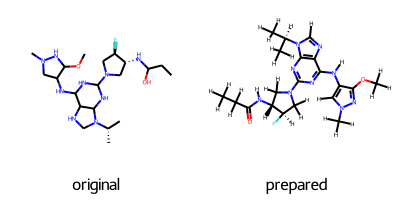

In [8]:
smiles = "CCC(=O)N[C@@H]1CN(C[C@H]1F)c2nc(Nc3cn(C)nc3OC)c4ncn(C(C)C)c4n2"
rdkit_ligand = prepare_ligand(str(pdb_path), "8AM", smiles)

### Merge protein and ligand

In the next step, we want to merge the prepared protein and ligand structures using the python package `MDTraj`. MDTraj can handle the prepared protein, which is currently an OpenMM like pdbfixer molecule. For the ligand however, we need to do several conversions, since it is currently an RDKit molecule.

In [9]:
def rdkit_to_openmm(rdkit_mol, name="LIG"):
    """Convert an RDKit molecule to an OpenMM molecule. Inspired by @hannahbrucemcdonald and @glass-w.
    
    Parameters
    ----------
    rdkit_mol: rdkit.Chem.rdchem.Mol
        RDKit molecule to convert.
    name: str
        Molecule name.
    
    Returns
    -------
    omm_molecule: simtk.openmm.app.Modeller
        OpenMM modeller object holding the molecule of interest.
    """
    # convert RDKit to OpenFF
    off_mol = Molecule.from_rdkit(rdkit_mol)

    # add name for molecule
    off_mol.name = name
    
    # add names for atoms
    element_counter_dict = {}
    for off_atom, rdkit_atom in zip(off_mol.atoms, rdkit_mol.GetAtoms()):
        element = rdkit_atom.GetSymbol()
        if element in element_counter_dict.keys():
            element_counter_dict[element] += 1
        else:
            element_counter_dict[element] = 1
        off_atom.name = element + str(element_counter_dict[element])

    # convert from OpenFF to OpenMM
    off_mol_topology = off_mol.to_topology()
    mol_topology = off_mol_topology.to_openmm()
    mol_positions = off_mol.conformers[0]
    
    # convert units from Ångström to Nanometers
    for atom in mol_positions:
        coords = atom / atom.unit
        atom = (coords / 10.0) * unit.nanometers  # since openmm works in nm
    
    # combine topology and positions in modeller object
    omm_mol = app.Modeller(mol_topology, mol_positions)
        
    return omm_mol

In [10]:
omm_ligand = rdkit_to_openmm(rdkit_ligand, "8AM")

Now protein and ligand are both in OpenMM like formats and can be merged with `MDTraj`.

In [11]:
def merge_protein_and_ligand(protein, ligand):
    """Merge two OpenMM structures.
  
    Parameters
    ----------
    protein: pdbfixer.pdbfixer.PDBFixer
        Protein to merge.
    ligand: simtk.openmm.app.Modeller
        Ligand to merge.
    
    Returns
    -------
    complex_topology: simtk.openmm.app.topology.Topology
        The merged topology.
    complex_positions: simtk.unit.quantity.Quantity
        The merged positions.
    """
    # combine topologies
    md_protein_topology = md.Topology.from_openmm(protein.topology)  # using mdtraj for protein top
    md_ligand_topology = md.Topology.from_openmm(ligand.topology)  # using mdtraj for ligand top
    md_complex_topology = md_protein_topology.join(md_ligand_topology)  # add them together
    complex_topology = md_complex_topology.to_openmm()

    # combine positions
    total_atoms = len(protein.positions) + len(ligand.positions)
    
    # create an OpenMM quantity array of right size
    complex_positions = unit.Quantity(np.zeros([total_atoms, 3]), unit=unit.nanometers)
    complex_positions[0: len(protein.positions)] = protein.positions  # add protein positions
    complex_positions[len(protein.positions) + 1: total_atoms] = ligand.positions  # add ligand positions

    return complex_topology, complex_positions

In [12]:
complex_topology, complex_positions = merge_protein_and_ligand(prepared_protein, omm_ligand)

### MD simulation set up

We can now use the prepared complex to set up the MD simulation. 

#### Force field

Common force fields like `AMBER` have parameters for amino acids, nucleic acids, water and ions. Parameters for ligands however are not included. To generate these parameters, we can use the **G**eneral **A**MBER **F**orce**F**ield (GAFF), which is implemented in the python package `openmmforcefields`. The following function generates a force field object holding standard AMBER paramaters and additionally includes parameters for a small molecule if required.

In [13]:
def generate_forcefield(rdkit_mol=None, protein_ff="amber14-all.xml", solvent_ff="amber14/tip3pfb.xml"):
    """Generate an OpenMM Forcefield object and register a small molecule.
  
    Parameters
    ----------
    rdkit_mol: rdkit.Chem.rdchem.Mol
        Small molecule to register in forcefield.
    protein_ff: string
        Name of the forcefield.
    solvent_ff: string
        Name of the solvent forcefield.

    Returns
    -------
    forcefield: simtk.openmm.app.Forcefield
        Forcefield with registered small molecule.
    """
    forcefield = app.ForceField(protein_ff, solvent_ff)

    if rdkit_mol is not None:
        gaff = GAFFTemplateGenerator(molecules=Molecule.from_rdkit(rdkit_mol))
        forcefield.registerTemplateGenerator(gaff.generator)

    return forcefield

In [14]:
forcefield = generate_forcefield(rdkit_ligand)

#### System

With our configured force field we can now create the MD environment containing the complex and add solvent we want to simulate in.

In [15]:
# add solvent
modeller = app.Modeller(complex_topology, complex_positions)
modeller.addSolvent(forcefield, padding=1.0 * unit.nanometers, ionicStrength=0.15 * unit.molar)

With our solvated system and forcefield we can finally create an OpenMM system and set up the simulation.

In [16]:
system = forcefield.createSystem(modeller.topology, nonbondedMethod=app.PME)
integrator = mm.LangevinIntegrator(300 * unit.kelvin, 1.0 / unit.picoseconds, 2.0 * unit.femtoseconds)
simulation = app.Simulation(modeller.topology, system, integrator)
simulation.context.setPositions(modeller.positions)

### Perform the MD simulation
Now that everything is set-up we can perform the simulation. We need to set starting positions and minimize the energy of the system to get a low energy starting configuration, which is important to decrease the chance of simulation failures due to severe atom clashes. The energy minimized system is saved.

Once the minimization has finished, we can perform the MD simulation. In this talktorial, we will simulate 100 ps of molecular dynamics corresponding to 50k steps of 2 fs each. We save molecular "snapshots" every 10 ps (5000 steps), for a total of 10 frames. The results are saved in an .xtc file, which contains the coordinates of all the atoms at a given time point. Together with the pdb file of the energy minimized system written before, it gives us all the information needed for later analysis.

In [17]:
# minimize energy
simulation.minimizeEnergy()
# write out minimized system
with open(DATA / "topology.pdb", "w") as pdb_file:
    app.PDBFile.writeFile(simulation.topology,
                      simulation.context.getState(getPositions=True, enforcePeriodicBox=True).getPositions(),
                      file=pdb_file,
                      keepIds=True)

In [18]:
# output settings
steps = 50000  # corresponds to 100 ps
write_interval = 5000  # write every 10 ps
log_interval = 2500  # log progress to stdout every 5 ps
simulation.reporters.append(md.reporters.XTCReporter(file=str(DATA / "trajectory.xtc"), reportInterval=write_interval))
simulation.reporters.append(app.StateDataReporter(sys.stdout, log_interval, step=True, potentialEnergy=True, 
                                                  temperature=True, progress=True, remainingTime=True,
                                                  speed=True, totalSteps=steps, separator='\t'))

In [19]:
# set random velocities
simulation.context.setVelocitiesToTemperature(300 * unit.kelvin)
# perform the simulation
simulation.step(steps)

#"Progress (%)"	"Step"	"Potential Energy (kJ/mole)"	"Temperature (K)"	"Speed (ns/day)"	"Time Remaining"
5.0%	2500	-915088.3484301772	295.7316416446826	0	--
10.0%	5000	-912464.8484301772	298.38414040198955	110	1:10
15.0%	7500	-911151.3484301772	301.4804474306923	110	1:06
20.0%	10000	-913068.3484301772	300.7353585955218	109	1:03
25.0%	12500	-911820.3484301772	300.9588310893395	109	0:59
30.0%	15000	-911519.5984301772	299.0045332167148	109	0:55
35.0%	17500	-912271.8484301772	299.1659234204909	109	0:51
40.0%	20000	-912527.8484301772	297.221515990635	108	0:47
45.0%	22500	-910494.3484301772	299.33508756366723	108	0:44
50.0%	25000	-911382.3484301772	300.28793968091406	108	0:40
55.0%	27500	-912857.8484301772	300.21514172849476	107	0:36
60.0%	30000	-911449.8484301772	300.64461170201076	107	0:32
65.0%	32500	-909814.3484301772	298.34525156824196	107	0:28
70.0%	35000	-912905.0984301772	300.8875586074726	106	0:24
75.0%	37500	-913089.3484301772	298.12128676141845	106	0:20
80.0%	40000	-910665.34843017

### Download results

You can execute the following cell if on Google Colab to download the MD simulation results.

In [20]:
files.download(DATA / "topology.pdb")
files.download(DATA / "trajectory.xtc")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Discussion

We have successfully performed an MD simulation of a protein ligand complex. However, we simulated only a considerably short time to keep the execution time of the talktorial short. To address critical questions in drug design, longer simulation times in the µs scale are often required. Also, we did not include an equilibration step, which is commenly used to slowly heat up the system from 0 to 300 K before starting the simulation and might be important when simulating more sensitive systems including lipid bilayers. The protonation of ligand and protein was done seperately, which is suboptimal, since protonation states of protein residues and ligand affect each other. However, we did not find a free and open-source solution meeting all requirements. Suggestions are very welcome!


If you want to learn how to visualize analyze the trajectory, you can refer to the next notebook in this repository.